In [1]:
import glob
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, mannwhitneyu
from skbio.stats.distance import permanova
from biom import Table
from skbio import DistanceMatrix, OrdinationResults
from skbio.stats.composition import closure
from biom import load_table
from gemelli.rpca import rpca_table_processing #rpca
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import all data

In [2]:
# import and match the data the same as in ../../simulations-benchmarking/3.0-ihmp-benchmarks.ipynb
# we will also save each table with all the data for that table
# for exploration non-jointly based on the joint samples
tables = {omics_.split('/')[-1].split('.')[0]:rpca_table_processing(load_table(omics_),
                                                                    min_sample_count=0,
                                                                    min_feature_count=0,
                                                                    min_feature_frequency=0)
          for omics_ in glob.glob('../../data/simulations/ihmp/*.biom')
          if not any ('_' + str(d_) in omics_ for d_ in [11, 9, 7, 5, 3])}

# add pathways instead of ECs (easier to interpret)
tbl_ = pd.read_csv('../../data/simulations/ihmp/additional-data/pathabundances_3.tsv', sep='\t', index_col=0)
tbl_ = tbl_[[('UNINTEGRATED' not in x) and ('UNMAPPED' not in x) for x in tbl_.index]]
tbl_.columns = [c.replace('_pathabundance_cpm','') for c in tbl_.columns]
tbl_ = tbl_.loc[tbl_.sum(1) > 0, tbl_.sum(0) > 0]
tbl_ = Table(tbl_.values, tbl_.index, tbl_.columns)
tables['meta_t_ecs'] = tbl_.copy()

In [3]:
metadata_shared = pd.read_csv('../../data/simulations/ihmp/sample-metadata-plus-train-tests-case-study.csv', index_col=0)
shared_samps = set.intersection(*[set(t_.ids()) for t_ in tables.values()]) & set(metadata_shared.index)

# re-close metaG/T data
metadata_shared = metadata_shared.reindex(shared_samps)
tables_shared = {t_k:t_.copy().filter(shared_samps) for t_k, t_ in tables.items()}
for t_ in ['meta_g_taxonomic_profiles','meta_t_ecs']:
    tbl_tmp = pd.DataFrame(tables_shared[t_].matrix_data.toarray(), 
                 tables_shared[t_].ids('observation'),
                 tables_shared[t_].ids())
    tbl_tmp = tbl_tmp.apply(closure)
    tables_shared[t_] = Table(tbl_tmp.values, tbl_tmp.index, tbl_tmp.columns)

In [4]:
metadata_shared.diagnosis_binned.value_counts()

IBD       91
nonIBD    44
Name: diagnosis_binned, dtype: int64

## Import all results

In [5]:
# import all other ordinations
ords_all = {}
perm_all = {}
ords_feat = {}
for ord_tmp in glob.glob('../../data/case-studies/ihmp/single-omics/*-*-ord.txt'):
    ord_name = ord_tmp.split('/')[-1].split('-')[0]
    if 'cohort_two' not in ord_tmp:
        print(ord_name)
        ord_tmp_res_ = OrdinationResults.read(ord_tmp)
        ord_tmp_res_ = pd.concat([ord_tmp_res_.samples, metadata_shared], axis=1, sort=False)
        ord_tmp_res_ = ord_tmp_res_.rename({0:'PC1', 1:'PC2', 2:'PC3'}, axis=1).dropna(subset=['PC1','diagnosis_binned'])
        dist_tmp = DistanceMatrix.read(ord_tmp.replace('ord','dist'))
        shared_ids = list(set(dist_tmp.ids) & set(ord_tmp_res_.index))
        ord_tmp_res_ = ord_tmp_res_.reindex(shared_ids)
        dist_tmp = dist_tmp.filter(shared_ids)
        perm_tmp = permanova(dist_tmp, 
                             ord_tmp_res_.loc[dist_tmp.ids, ['diagnosis_binned']].iloc[:,0],
                             permutations=2000)
        print(perm_tmp)
        f_, p_ = perm_tmp[['test statistic','p-value']].values
        perm_all[ord_tmp.split('/')[-1].split('-')[0], 
                 ord_tmp.split('/')[-1].split('-')[1]] = [f_, p_]
        ords_all[ord_tmp.split('/')[-1].split('-')[0], 
                 ord_tmp.split('/')[-1].split('-')[1]] = ord_tmp_res_
        ords_feat[ord_tmp.split('/')[-1].split('-')[0], 
                 ord_tmp.split('/')[-1].split('-')[1]] = OrdinationResults.read(ord_tmp).features
        print()

HMP2_proteomics_ecs
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     135
number of groups                  2
test statistic             8.575801
p-value                       0.001
number of permutations         2000
Name: PERMANOVA results, dtype: object

virome_virmap_analysis
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     135
number of groups                  2
test statistic             2.010729
p-value                    0.008996
number of permutations         2000
Name: PERMANOVA results, dtype: object

HMP2_metabolomics
method name               PERMANOVA
test statistic name        pseudo-F
sample size                     135
number of groups                  2
test statistic            18.753309
p-value                      0.0005
number of permutations         2000
Name: PERMANOVA results, dtype: object

HMP2_proteomics_ecs
method name               PERMANOVA
test st

In [6]:
#MOFA+ with CLR and no train-test splits
mofa_ord = pd.read_csv('../../data/case-studies/ihmp/mofa-results/clr-all-factors.csv', index_col=0)
mofa_ord = mofa_ord.pivot(index='sample', columns='factor', values='value')
mofa_ord_plot = pd.concat([mofa_ord, metadata_shared], axis=1, sort=False)
mofa_ord_plot = mofa_ord_plot.rename({'Factor1':'PC1', 'Factor2':'PC2', 'Factor3':'PC3'}, axis=1)

#MOFA+ with RCLR and no train-test splits
mofa_ord_rclr = pd.read_csv('../../data/case-studies/ihmp/mofa-results/rclr-alldata-factors.csv', index_col=0)
mofa_ord_rclr = mofa_ord_rclr.pivot(index='sample', columns='factor', values='value')
mofa_ord_rclr_plot = pd.concat([mofa_ord_rclr, metadata_shared], axis=1, sort=False)
mofa_ord_rclr_plot = mofa_ord_rclr_plot.rename({'Factor1':'PC1', 'Factor2':'PC2', 'Factor3':'PC3'}, axis=1)

In [7]:
# Joint-RPCA
dist_ = DistanceMatrix.read('../../data/case-studies/ihmp/joint-rpca/dist.txt')
ord_ = OrdinationResults.read('../../data/case-studies/ihmp/joint-rpca/ord.txt')
ord_.samples.columns = ['PC1','PC2','PC3']
ordindation_samples = pd.concat([ord_.samples, metadata_shared], axis=1, sort=False).rename({0:'PC1', 1:'PC2', 2:'PC3'}, axis=1)

# add mixomics
mixomics_ord = {}
micomics_all = pd.read_csv('../../data/case-studies/ihmp/other-tools/mixomics-loadings.csv', index_col=0)
relabel = {'metabolomics':'HMP2_metabolomics',
            'metatranscriptomics':'meta_t_ecs',
            'proteomics':'HMP2_proteomics_ecs',
            'viromes':'virome_virmap_analysis',
            'metagenomics':'meta_g_taxonomic_profiles'}
for omic_, df_ in micomics_all.groupby('.id'):
    df_ = df_.set_index('subject').rename({'comp1':'PC1', 'comp2':'PC2', 'comp3':'PC3'}, axis=1).drop(['.id'], axis=1)
    mixomics_ord[relabel[omic_], 'mixOmics'] = pd.concat([df_, metadata_shared], axis=1, sort=False)
    
# other two tools
iclust = pd.read_csv('../../data/case-studies/ihmp/other-tools/iCluster-loadings.csv', index_col=0)
iclust.columns = ['PC1','PC2','PC3']
iclust_ordindation_samples = pd.concat([iclust, metadata_shared], axis=1, sort=False)
intnmf = pd.read_csv('../../data/case-studies/ihmp/other-tools/intNMF-loadings.csv', index_col=0)
intnmf.columns = ['PC1','PC2','PC3']
intnmf_ordindation_samples = pd.concat([intnmf, metadata_shared], axis=1, sort=False)
mixOmics_ordindation_samples = mixomics_ord[('HMP2_metabolomics', 'mixOmics')].copy()

In [8]:
#repeat permanova for joint-rpca
ord_tmp_res_joint_ = ordindation_samples.dropna(subset=['PC1','diagnosis_binned'])
shared_ids = list(set(dist_tmp.ids) & set(ord_tmp_res_joint_.index))
ord_tmp_res_joint_ = ord_tmp_res_joint_.reindex(shared_ids)
dist_joint_res_ = dist_.copy().filter(shared_ids)
perm_tmp_joint = permanova(dist_joint_res_, 
                           ord_tmp_res_joint_.loc[dist_joint_res_.ids, ['diagnosis_binned']].iloc[:,0],
                           permutations=2000)
f_, p_ = perm_tmp_joint[['test statistic','p-value']].values
print(perm_tmp_joint)
print(f_, p_)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     135
number of groups                  2
test statistic            17.037908
p-value                      0.0005
number of permutations         2000
Name: PERMANOVA results, dtype: object
17.037908309753586 0.0004997501249375312


# Ordinations plot

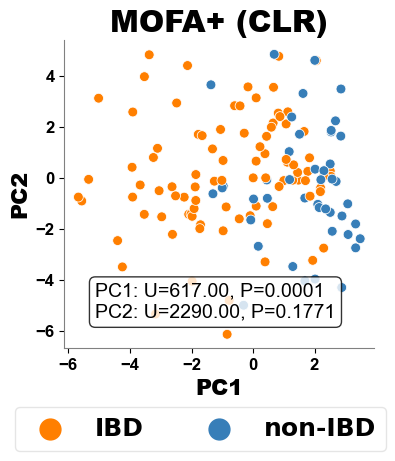

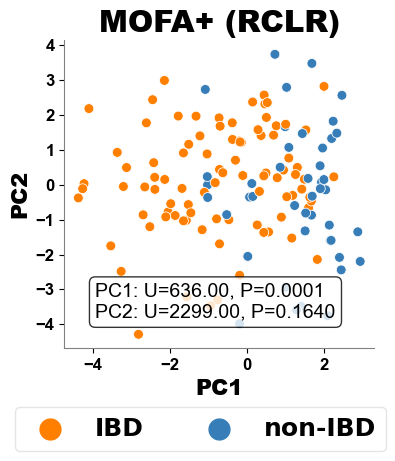

In [9]:
#compare results from MOFA with CLR/RCLR-transformed data
for mofa_res_, title_ in zip([mofa_ord_plot, mofa_ord_rclr_plot],
                            ['CLR', 'RCLR']):

    fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    pal_ =  {'IBD':'#ff7f00', 'non-IBD':'#377eb8'}

    mofa_res_['diagnosis_binned'] = mofa_res_['diagnosis_binned'].replace('nonIBD', 'non-IBD')

    sns.scatterplot(x='PC1', y='PC2', hue='diagnosis_binned', s=50,
                    data=mofa_res_, ax=ax, palette=pal_)

    txt_s = []
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    for pc_ in ['PC1','PC2']:
        f_, p_ = mannwhitneyu(mofa_res_[mofa_res_.diagnosis_binned == 'IBD'][pc_].values,
                              mofa_res_[mofa_res_.diagnosis_binned != 'IBD'][pc_].values)
        if p_ < 0.0001:
            p_ = 0.0001
        txt_s.append('%s: U=%.2f, P=%.4f' % (pc_, f_, p_))
    ax.text(0.1, 0.1, '\n'.join(txt_s), fontsize=14, 
            color='black', fontname = 'Arial',
            transform=ax.transAxes, bbox=props)
        
    ax.set_xlabel('PC1',
                color='black',
                weight='bold',
                fontsize=16,
                fontname = 'Arial Black')
    ax.set_ylabel('PC2',
                color='black',
                fontsize=16,
                fontname = 'Arial Black')
    ax.set_title('MOFA+ (%s)' %title_,
                color='black',
                fontsize=22,
                fontname = 'Arial Black')

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('Arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(12)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('Arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(12)
        
    # generate legend from last iterations     
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[:], labels[:], loc=2, 
                            bbox_to_anchor=(-0.2, -.15),
                            prop={'size':18, 'weight':'bold'},
                            fancybox=True, framealpha=.5,
                            ncol=2, markerscale=2.5)
    legend.get_title().set_fontsize('14')
    # increase the line width in the legend 
    for line in legend.get_lines()[:]:
        line.set_linewidth(4.0)
    for line in legend.get_lines()[:]:
        line.set_linewidth(4.0)

    plt.show()

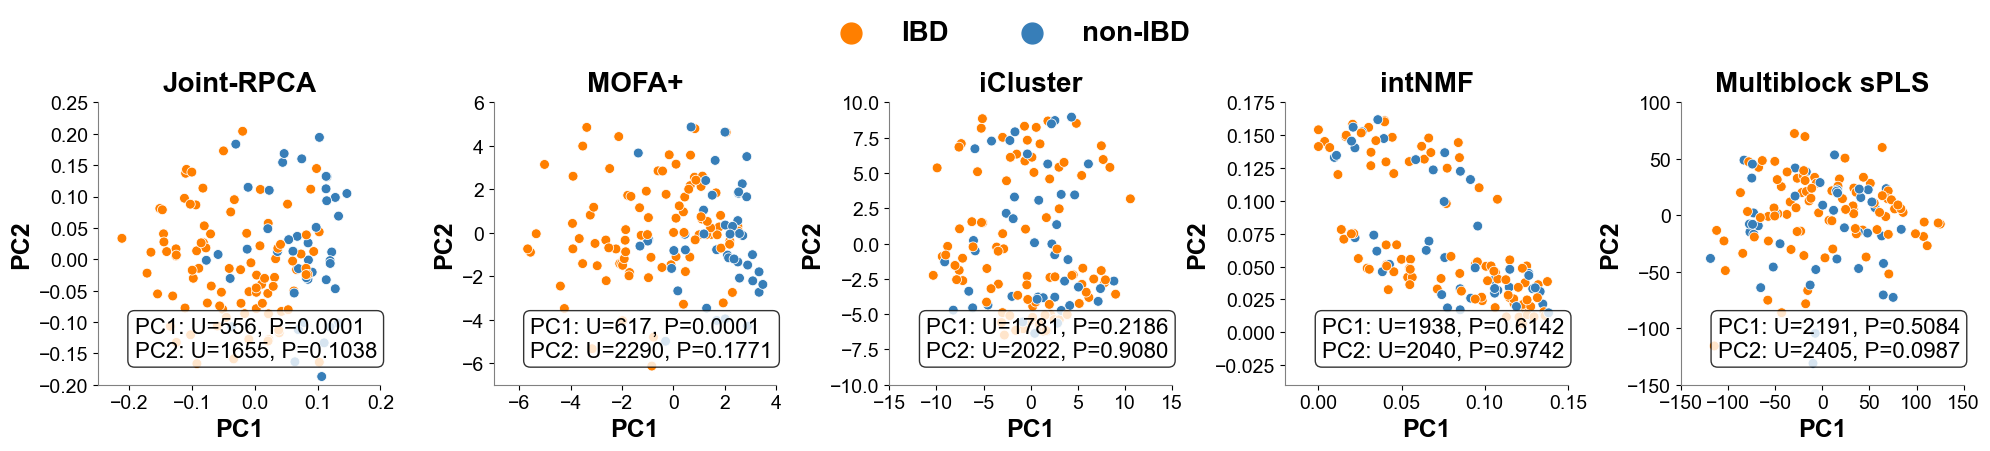

In [10]:
fig, axn = plt.subplots(1, 5, figsize=(20, 4))

pal_ =  {'IBD':'#ff7f00', 'non-IBD':'#377eb8'}

lims_ = {'Joint-RPCA':[(-.2, .25), (-.25, .2)],
         'MOFA+': [(-7, 6), (-7, 4)],
         'iCluster':[(-10, 10), (-15, 15)],
         'intNMF':[(-0.04, 0.175), (-0.02, 0.15)],
         'Multiblock sPLS':[(-150, 100), (-150, 150)]}

for ax, ordindation_samples_plt, title_ in zip(axn.flatten(), 
                                              [ordindation_samples.copy().rename({0:'PC1', 1:'PC2', 2:'PC3'}, axis=1), 
                                               mofa_ord_plot,
                                               iclust_ordindation_samples, 
                                               intnmf_ordindation_samples,
                                               mixOmics_ordindation_samples],
                                              ['Joint-RPCA','MOFA+','iCluster','intNMF','Multiblock sPLS']):

    ordindation_samples_plt['diagnosis_binned'] = ordindation_samples_plt['diagnosis_binned'].replace('nonIBD', 'non-IBD')
    sns.scatterplot(x='PC1', y='PC2', hue='diagnosis_binned', s=50, data=ordindation_samples_plt, ax=ax, palette=pal_)
    txt_s = []
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    for pc_ in ['PC1','PC2']:
        f_, p_ = mannwhitneyu(ordindation_samples_plt[ordindation_samples_plt.diagnosis_binned == 'IBD'].dropna(subset=[pc_])[pc_].values,
                              ordindation_samples_plt[ordindation_samples_plt.diagnosis_binned != 'IBD'].dropna(subset=[pc_])[pc_].values)
        if p_ < 0.0001:
            p_ = 0.0001
        txt_s.append('%s: U=%d, P=%.4f' % (pc_, f_, p_))
    ax.text(0.13, 0.1, '\n'.join(txt_s), fontsize=16, color='black', 
            fontname='Arial', transform=ax.transAxes, bbox=props)

    ax.set_xlabel('PC1', fontname='Arial',
                  color='black', weight='bold', fontsize=18)
    ax.set_ylabel('PC2', fontname='Arial',
                  color='black', weight='bold', fontsize=18)
    ax.set_title(title_, y=1.01, fontname='Arial',
                  color='black', weight='bold', fontsize=20)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(14)
    ax.legend_.remove()
    ax.set_ylim(lims_[title_][0])
    ax.set_xlim(lims_[title_][1])
    #ax.locator_params(axis='y', nbins=5)
    
plt.tight_layout()
plt.subplots_adjust(wspace=0.4) 

#generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[:], labels[:], #loc=2, 
                    bbox_to_anchor=(-1.65, 1.38),
                    prop={'size':20, 'weight':'bold', 'family': 'Arial'},
                    fancybox=True, framealpha=0,
                    ncol=2, markerscale=2.5)
legend.get_title().set_fontsize('20')
#increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(4.0)

plt.savefig('../../results/figure-2A.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/figure-2A.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

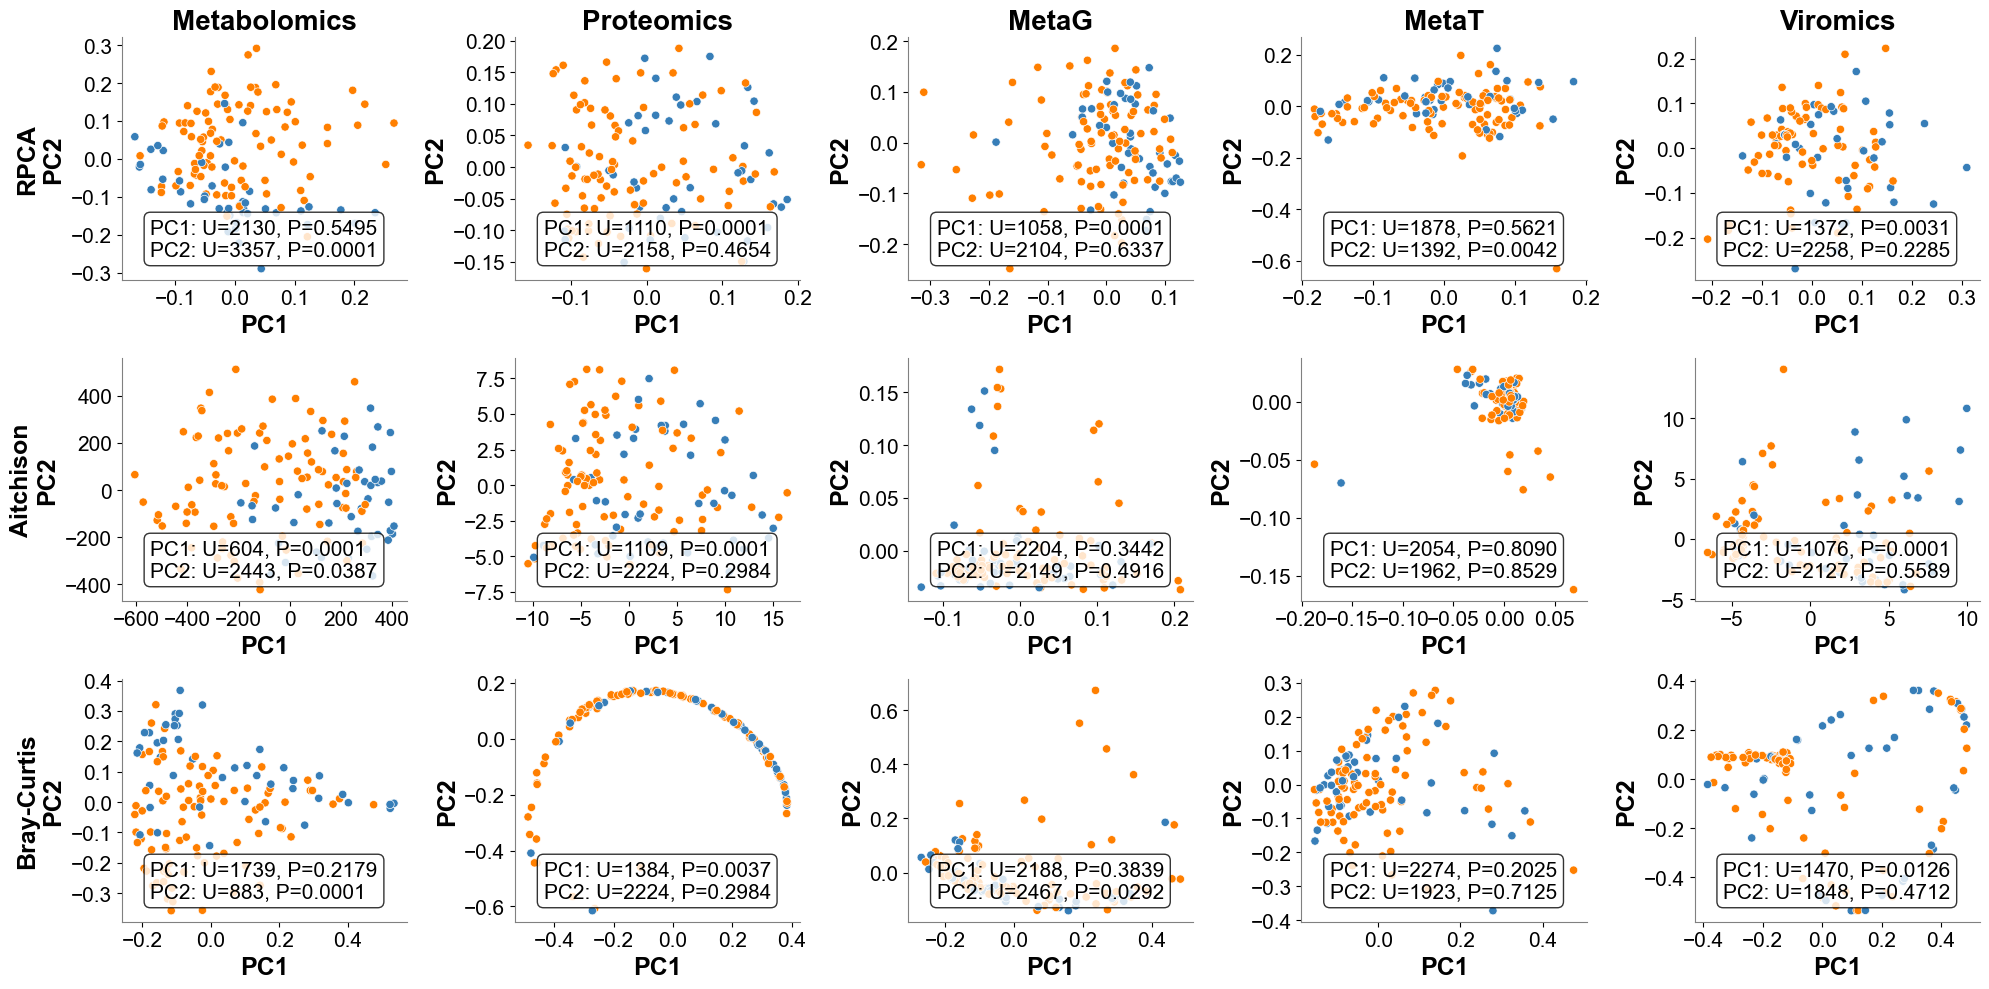

In [11]:
fig, axn = plt.subplots(3, 5, figsize=(20, 10))

ords_all_combined = {**ords_all, **mofa_ord}

pal_ =  {'IBD':'#ff7f00', 'nonIBD':'#377eb8'}

lbl_map_one = {'HMP2_metabolomics':'Metabolomics',
               'HMP2_proteomics_ecs':'Proteomics',
               'meta_g_taxonomic_profiles':'MetaG',
               'meta_t_ecs':'MetaT',
               'virome_virmap_analysis':'Viromics'}

lbl_map_two = {'RPCA':'RPCA', 
               'aitchison':'Aitchison', 
               'braycurtis':'Bray-Curtis'}

order_ = [(x, y)
          for x in lbl_map_one.keys()
          for y in lbl_map_two.keys()]

for ax, title_ in zip(axn.T.flatten(), order_):

    ord_plt = ords_all_combined[(title_[0], title_[1])]
    sns.scatterplot(x='PC1', y='PC2', hue='diagnosis_binned',
                    data=ord_plt, ax=ax, palette=pal_)

    ax.set_xlabel('PC1', fontname='Arial',
                  color='black', weight='bold', fontsize=18)

    if 'HMP2_metabolomics' in title_:
        ax.set_ylabel('{}\nPC2'.format(lbl_map_two[title_[1]]),
                    fontname='Arial', color='black', 
                    weight='bold', fontsize=18)
    else:
        ax.set_ylabel('PC2',fontname='Arial',
                      color='black', weight='bold', fontsize=18)
    
    if title_[1] == 'RPCA':
        ax.set_title(lbl_map_one[title_[0]],
                      weight='bold',
                      fontname = 'Arial',
                      fontsize=20)
    else:
        ax.set_title('', color='black',
                     fontname = 'Arial',
                     fontsize=20)
    
    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(15)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(15)
    ax.legend_.remove()
    
    txt_s = []
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    for pc_ in ['PC1','PC2']:
        f_, p_ = mannwhitneyu(ord_plt[ord_plt.diagnosis_binned == 'IBD'].dropna(subset=[pc_])[pc_].values, 
                              ord_plt[ord_plt.diagnosis_binned != 'IBD'].dropna(subset=[pc_])[pc_].values)
        if p_ < 0.0001:
            p_ = 0.0001
        txt_s.append('%s: U=%d, P=%.4f' % (pc_, f_, p_))
    ax.text(0.1, 0.1, '\n'.join(txt_s), 
            fontsize=15, color='black', fontname='Arial', 
            transform=ax.transAxes, bbox=props)
    
#plt.tight_laout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, 
                    top=0.9, wspace=0.3, hspace=0.3)
plt.tight_layout()

plt.savefig('../../results/supp-fig1.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/supp-fig1.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

# Log-ratio analysis

In [12]:
pc_ = 0
ranks_results_rpca = {}
min_f_use = 10
max_f_use = 100

ord_feat = ord_.features.copy()
for omics_, bt_tmp in tables_shared.items():
    
    if omics_ == 'shared_meta_g_taxonomic_profiles':
        continue

    if omics_ == 'virome_virmap_analysis':
        min_f_use = 2
        max_f_use = 10
        
    if omics_ == 'shared_meta_g_taxonomic_profiles':
        min_f_use = 10
        max_f_use = 100
        
    if omics_ == 'meta_t_ecs':
        min_f_use = 500
        max_f_use = 100000        
        
    else:
        min_f_use = 10
        max_f_use = 100

    #print(omics_)
    X_min = bt_tmp.matrix_data.toarray() 
    min_ps = X_min[X_min != 0].min()
    tdf = pd.DataFrame(bt_tmp.matrix_data.toarray() + min_ps, bt_tmp.ids('observation'), bt_tmp.ids())
    metadata_lr = metadata_shared.copy()
    to_keep = set(ord_feat.index) & set(tdf.index)
    feat_rank = ord_feat.loc[list(to_keep), :].sort_values(pc_)
    for f_use in range(min_f_use, max_f_use):
        lr_ = np.log(tdf.loc[feat_rank.index[:f_use], :].sum(0)) \
              - np.log(tdf.loc[feat_rank.index[-f_use:], :].sum(0))
        lr_[~np.isfinite(lr_)] = np.nan
        if (f_use * 2) >= tdf.shape[0]:
            break
        if ((lr_.shape[0] - sum(np.isnan(lr_))) / lr_.shape[0]) > 0.99:
            break
        if omics_ == 'HMP2_proteomics_ecs':
            break
    tdf += tdf.values.mean()
    lr_ = np.log(tdf.loc[feat_rank.index[:f_use], :].sum(0)) \
              - np.log(tdf.loc[feat_rank.index[-f_use:], :].sum(0))
    metadata_lr = metadata_lr.loc[tdf.columns, :]
    metadata_lr[omics_ + 'log_ratio'] = lr_
    print(omics_, f_use)

    # remove multiple time points
    metadata_lr['diagnosis_binned'] = [x.replace('UC','IBD').replace('CD','IBD')
                                           for x in metadata_lr.diagnosis_binned]
    metadata_lr_single = metadata_lr.sort_values('week_num')
    metadata_lr_single['External ID'] = metadata_lr_single.index
    metadata_lr_single = metadata_lr_single.groupby('Participant ID').first()
    metadata_lr_single.index = metadata_lr_single['External ID']

    # get time series data
    p_count = metadata_lr['Participant ID'].value_counts()
    metadata_lr_time = metadata_lr[metadata_lr['Participant ID'].isin(p_count[p_count > 1].index)]
    t_no_compare = [t_ for t_, tdf_ in  metadata_lr_time.groupby('week_num')
                    if (len(set(tdf_.diagnosis_binned)) < 2) \
                    or (tdf_.diagnosis_binned.value_counts().min() < 2)]
    metadata_lr_time = metadata_lr_time[~metadata_lr_time.week_num.isin(t_no_compare)]
    
    # save results used
    ranks_results_rpca[omics_] = [metadata_lr_single,
                             metadata_lr_time,
                             feat_rank.index[:f_use],
                             feat_rank.index[-f_use:]]

virome_virmap_analysis 10
meta_t_ecs 500
meta_g_taxonomic_profiles 10
HMP2_proteomics_ecs 10
HMP2_metabolomics 10


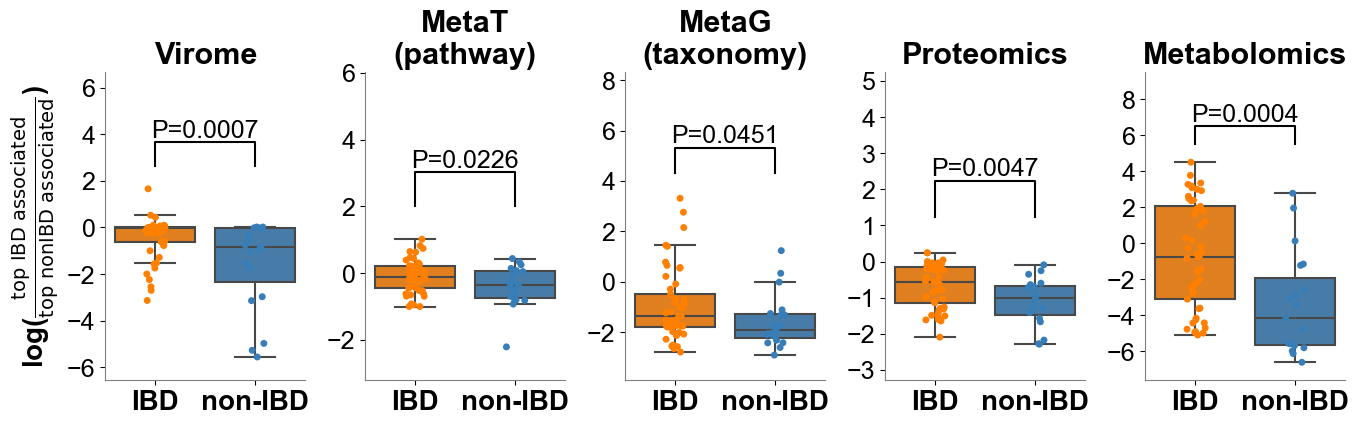

In [13]:
title_bls = {'HMP2_metabolomics':'Metabolomics',
             'shared_meta_g_taxonomic_profiles':'MetaG\n(taxonomy)',
             'meta_g_taxonomic_profiles':'MetaG\n(taxonomy)',
             'virome_virmap_analysis':'Virome',
             'HMP2_proteomics_ecs':'Proteomics',
             'meta_t_ecs':'MetaT\n(pathway)'}
pal_ =  {'IBD':'#ff7f00', 'non-IBD':'#377eb8'}

fig, axn = plt.subplots(1, len(ranks_results_rpca), figsize=(16, 4), 
                        sharex=True, sharey=False)

axn = axn.flatten()

#reorder dict to match figure order in manuscript
omic_order = ['virome_virmap_analysis', 'meta_t_ecs', 'meta_g_taxonomic_profiles',
              'HMP2_proteomics_ecs', 'HMP2_metabolomics']
ranks_results_rpca_ = {k : ranks_results_rpca[k] for k in omic_order}

for ax, (omics_, (metadata_lr_single, _, _, _)) in zip(axn, ranks_results_rpca_.items()):
    
    metadata_lr_single['diagnosis_binned'] = [x.replace('nonIBD','non-IBD') for x in metadata_lr_single['diagnosis_binned']]
    sns.boxplot(y=omics_ + 'log_ratio', x='diagnosis_binned', data=metadata_lr_single, ax=ax, palette=pal_, showfliers=False)
    sns.stripplot(y=omics_ + 'log_ratio', x='diagnosis_binned', data=metadata_lr_single, ax=ax, palette=pal_)
    ax.set_title(title_bls[omics_], color='black', weight='bold', fontsize=22, fontname='Arial')
    
    # statistical annotation
    a_ = metadata_lr_single[metadata_lr_single.diagnosis_binned == 'IBD'][omics_ + 'log_ratio'].dropna()
    b_ = metadata_lr_single[metadata_lr_single.diagnosis_binned != 'IBD'][omics_ + 'log_ratio'].dropna()
    U_, p_ = ttest_ind(b_, a_, alternative='less')
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = np.max([np.max(a_), np.max(b_)]) + 1, 1, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, "P=%.4f" %(p_), ha='center',
            va='bottom', color=col, fontsize=18, fontname='Arial')
    ax.set_ylim(np.min([np.min(a_), np.min(b_)]) - 1, 
                np.max([np.max(a_), np.max(b_)]) + 5)

for ax in axn:
    ax.set_xlabel('', color='black', weight='bold', fontsize=18, fontname='Arial')
    ax.set_ylabel('', color='black', weight='bold', fontsize=18, fontname='Arial')

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    
    labels = [tick.get_text() for tick in ax.get_xticklabels()]
    labels = [l.replace('MOFA', 'MOFA+') for l in labels]
    labels = [l.replace('mixOmics', 'Multiblock sPLS') for l in labels]
    ax.set_xticklabels(labels)

    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_weight("bold")
        tick.set_fontsize(20)

axn[0].set_ylabel('log($\\frac{\\mathrm{top\,\,IBD\,\,associated}}{\\mathrm{top\,\,nonIBD\,\,associated}}$)',
                  fontname='Arial', color='black', weight='bold', fontsize=20)
        
plt.subplots_adjust(wspace=0.3)

# plt.savefig('../../results/figure-4A.pdf',
#             dpi=600, 
#             bbox_inches='tight',
#             facecolor=fig.get_facecolor(), 
#             edgecolor='none')
# plt.savefig('../../results/figure-4A.png',
#             dpi=600, 
#             bbox_inches='tight',
#             facecolor=fig.get_facecolor(), 
#             edgecolor='none')
plt.show()


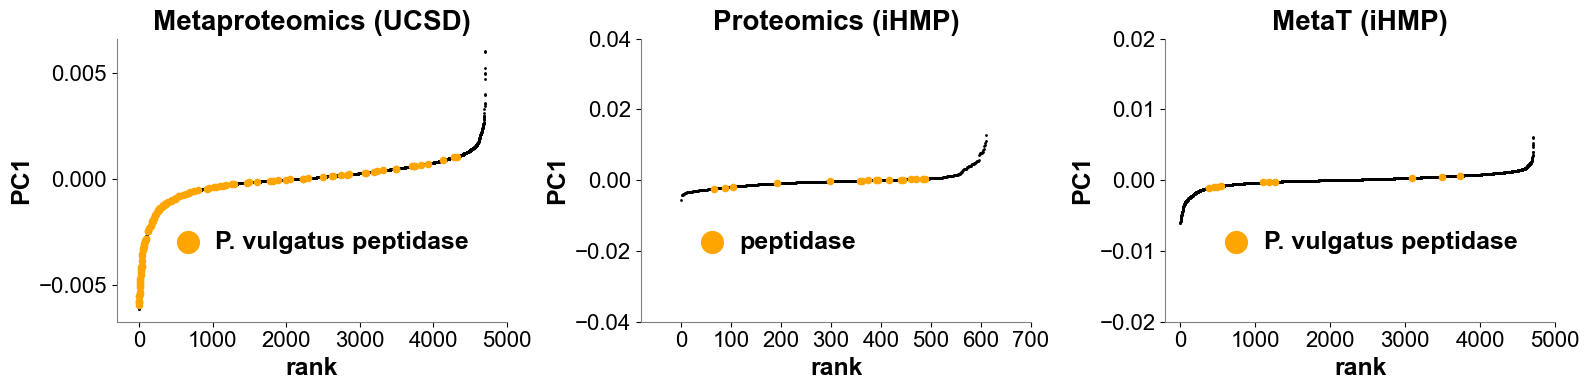

In [14]:
fig, axn = plt.subplots(1, 3, figsize=(16, 4))
pc_ = 0

# (1)
ax = axn[0]
tdf = pd.DataFrame(tables_shared['meta_t_ecs'].matrix_data.toarray(),
                   tables_shared['meta_t_ecs'].ids('observation'),
                   tables_shared['meta_t_ecs'].ids())
feat_rank_mt = ord_feat.loc[list(set(ord_feat.index) & set(tdf.index)), :].sort_values(pc_)
feat_rank_mt['peptidase'] = ['vulgatus' in x for x in  feat_rank_mt.index]
feat_rank_mt = feat_rank_mt.sort_values(pc_)
feat_rank_mt['rank'] = feat_rank_mt.reset_index().index
feat_rank_ = feat_rank_mt[feat_rank_mt[1].abs() < 0.06]
ax.scatter(feat_rank_[feat_rank_.peptidase == False]['rank'].values,
           feat_rank_[feat_rank_.peptidase == False][pc_].values,
           color='black', s=1)
ax.scatter(feat_rank_[feat_rank_.peptidase == True]['rank'].values,
           feat_rank_[feat_rank_.peptidase == True][pc_].values,
           color='orange', s=20, label='P. vulgatus peptidase')
ax.set_xlim(-300, 5000)

# (2)
ax = axn[1]
tdf = pd.DataFrame(tables_shared['HMP2_proteomics_ecs'].matrix_data.toarray(),
                   tables_shared['HMP2_proteomics_ecs'].ids('observation'),
                   tables_shared['HMP2_proteomics_ecs'].ids())
feat_rank = ord_feat.loc[list(set(ord_feat.index) & set(tdf.index)), :].sort_values(pc_)
feat_rank['peptidase'] = ['peptidase' in x for x in  feat_rank.index]
feat_rank = feat_rank.sort_values(pc_)
feat_rank['rank'] = feat_rank.reset_index().index
feat_rank_ = feat_rank[feat_rank[1].abs() < 0.06]
ax.scatter(feat_rank_[feat_rank_.peptidase == False]['rank'].values,
           feat_rank_[feat_rank_.peptidase == False][pc_].values,
           color='black', s=1)
ax.scatter(feat_rank_[feat_rank_.peptidase == True]['rank'].values,
           feat_rank_[feat_rank_.peptidase == True][pc_].values,
           color='orange', s=20, label='peptidase')
ax.set_ylim(-0.04, 0.04)
ax.set_xlim(-80, 700)

# (3)
ax = axn[2]
tdf = pd.DataFrame(tables_shared['meta_t_ecs'].matrix_data.toarray(),
                   tables_shared['meta_t_ecs'].ids('observation'),
                   tables_shared['meta_t_ecs'].ids())
feat_rank_mt = ord_feat.loc[list(set(ord_feat.index) & set(tdf.index)), :].sort_values(pc_)
feat_rank_mt['peptidase'] = [('vulgatus' in x) & ('peptid'  in x) for x in  feat_rank_mt.index]
feat_rank_mt = feat_rank_mt.sort_values(pc_)
feat_rank_mt['rank'] = feat_rank_mt.reset_index().index
#feat_rank_ = feat_rank_mt[feat_rank_mt[1].abs() < 0.06]
ax.scatter(feat_rank_mt[feat_rank_mt.peptidase == False]['rank'].values,
           feat_rank_mt[feat_rank_mt.peptidase == False][pc_].values,
           color='black', s=1)
ax.scatter(feat_rank_mt[feat_rank_mt.peptidase == True]['rank'].values,
           feat_rank_mt[feat_rank_mt.peptidase == True][pc_].values,
           color='orange', s=20, label='P. vulgatus peptidase')
ax.set_ylim(-0.02, 0.02)
ax.set_xlim(-200, 5000)

for ax in axn:

    # fix backround
    ax.set_facecolor('white')
    ax.patch.set_alpha(0.)
    ax.grid(False)
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(16)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(16)
    ax.locator_params(axis='y', nbins=5)

    ax.set_xlabel('rank', color='black', weight='bold',
                  fontsize=18, fontname='Arial')
    ax.set_ylabel('PC1', color='black', weight='bold',
                  fontsize=18, fontname='Arial')

    legend = ax.legend(loc=2,  bbox_to_anchor=(0.06, 0.4),
               prop={'size':18,'weight':'bold', 'family':'Arial'},
               title="", fancybox=True,framealpha=.0,
               ncol=1, markerscale=3.5, handletextpad=0.1)
    
axn[0].set_title('Metaproteomics (UCSD)', color='black',
                  weight='bold', fontsize=20, fontname='Arial')
axn[1].set_title('Proteomics (iHMP)', color='black',
                  weight='bold', fontsize=20, fontname='Arial')
axn[2].set_title('MetaT (iHMP)', color='black',
                  weight='bold', fontsize=20, fontname='Arial')

plt.tight_layout()

# plt.savefig('../../results/figure-4F.pdf',
#             dpi=600, 
#             bbox_inches='tight',
#             facecolor=fig.get_facecolor(), 
#             edgecolor='none')
# plt.savefig('../../results/figure-4F.png',
#             dpi=600, 
#             bbox_inches='tight',
#             facecolor=fig.get_facecolor(), 
#             edgecolor='none')

plt.show()

# RPCAs

In [15]:
# import all RPCA ordinations
ords_all = {}
perm_all = {}
ords_feat = {}
metadata_shared = pd.read_csv('../../data/simulations/ihmp/sample-metadata-plus-train-tests-case-study.csv', index_col=0)

for ord_tmp in glob.glob('../../data/case-studies/ihmp/single-omics/*-RPCA-ord.txt'):    
    ord_tmp_res_ = OrdinationResults.read(ord_tmp)
    ord_tmp_res_ = pd.concat([ord_tmp_res_.samples, metadata_shared], axis=1, sort=False)
    ord_tmp_res_ = ord_tmp_res_.rename({0:'PC1', 1:'PC2', 2:'PC3'}, axis=1)
    ords_all[ord_tmp.split('/')[-1].split('-')[0], 
             ord_tmp.split('/')[-1].split('-')[1]] = ord_tmp_res_
    ords_feat[ord_tmp.split('/')[-1].split('-')[0], 
             ord_tmp.split('/')[-1].split('-')[1]] = OrdinationResults.read(ord_tmp).features
    dist_tmp = DistanceMatrix.read(ord_tmp.replace('ord','dist'))

#joint-rpca
ord_ = OrdinationResults.read('../../data/case-studies/ihmp/joint-rpca/ord.txt')

In [17]:
del tables_shared['shared_meta_g_taxonomic_profiles']
ranks_results_rpca = {}
pc_ = 0
min_f_use = 10
max_f_use = 100

ord_feat = ord_.features.copy()
for omics_, bt_tmp in tables_shared.items():
    
    if omics_ == 'virome_virmap_analysis':
        min_f_use = 10
        max_f_use = 20
    else:
        min_f_use = 10
        max_f_use = 100
        
    tdf = pd.DataFrame(bt_tmp.matrix_data.toarray(), bt_tmp.ids('observation'), bt_tmp.ids())
    #metadata_lr = meta_.copy()
    metadata_lr = metadata_shared.copy()
    ord_feat_tmp = ords_feat[(omics_, 'RPCA')].copy()
    feat_rank = ord_feat_tmp.loc[list(set(ord_feat.index) & set(tdf.index)), :].sort_values(pc_)
    for f_use in range(min_f_use, max_f_use):
        lr_ = np.log(tdf.loc[feat_rank.index[:f_use], :].sum(0)) \
              - np.log(tdf.loc[feat_rank.index[-f_use:], :].sum(0))
        lr_[~np.isfinite(lr_)] = np.nan
        if (f_use * 2) >= tdf.shape[0]:
            break
        if ((lr_.shape[0] - sum(np.isnan(lr_))) / lr_.shape[0]) > 0.99:
            break
        if omics_ == 'HMP2_proteomics_ecs':
            break
    tdf += tdf.values.mean()
    lr_ = np.log(tdf.loc[feat_rank.index[:f_use], :].sum(0)) \
              - np.log(tdf.loc[feat_rank.index[-f_use:], :].sum(0))
    metadata_lr = metadata_lr.loc[tdf.columns, :]
    metadata_lr[omics_ + 'log_ratio'] = lr_
    
    # remove multiple time points
    metadata_lr['diagnosis_binned'] = [x.replace('UC','IBD').replace('CD','IBD')
                                           for x in metadata_lr.diagnosis]
    metadata_lr_single = metadata_lr.sort_values('week_num')
    metadata_lr_single['External ID'] = metadata_lr_single.index
    metadata_lr_single = metadata_lr_single.groupby('Participant ID').first()
    metadata_lr_single.index = metadata_lr_single['External ID']

    # get time series data
    p_count = metadata_lr['Participant ID'].value_counts()
    metadata_lr_time = metadata_lr[metadata_lr['Participant ID'].isin(p_count[p_count > 1].index)]
    t_no_compare = [t_ for t_, tdf_ in  metadata_lr_time.groupby('week_num')
                    if (len(set(tdf_.diagnosis_binned)) < 2) \
                    or (tdf_.diagnosis_binned.value_counts().min() < 2)]
    metadata_lr_time = metadata_lr_time[~metadata_lr_time.week_num.isin(t_no_compare)]
    
    # save results used
    ranks_results_rpca[omics_] = [metadata_lr_single,
                                  metadata_lr_time,
                                  feat_rank.index[:f_use],
                                  feat_rank.index[-f_use:]]

/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/joint-rpca-benchmarking-flex/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  r

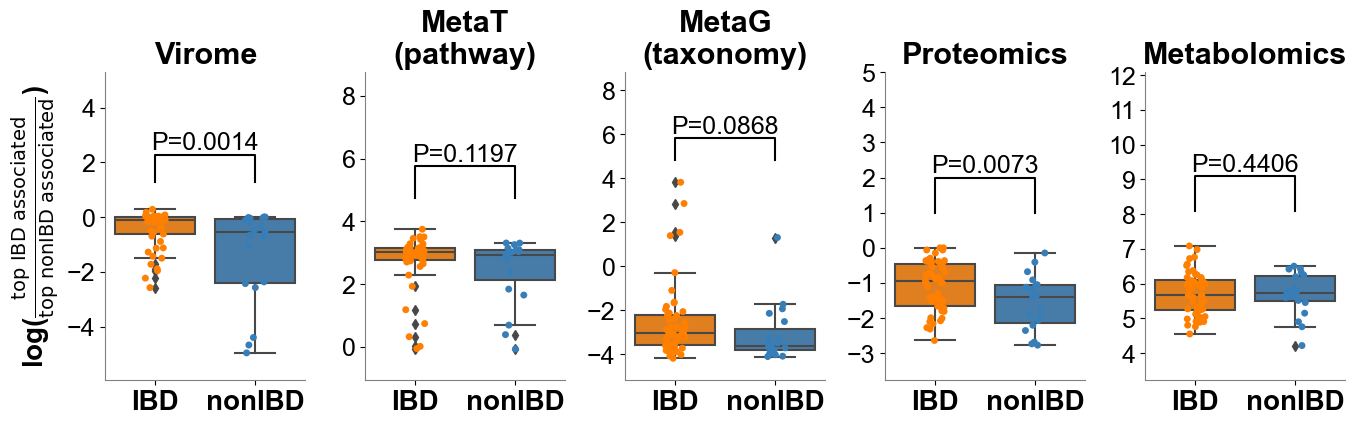

In [24]:
title_bls = {'HMP2_metabolomics':'Metabolomics',
             'meta_g_taxonomic_profiles':'MetaG\n(taxonomy)',
             'virome_virmap_analysis':'Virome',
             'HMP2_proteomics_ecs':'Proteomics',
             'meta_t_ecs':'MetaT\n(pathway)'}
pal_ =  {'IBD':'#ff7f00', 'nonIBD':'#377eb8'}

fig, axn = plt.subplots(1, len(ranks_results_rpca), figsize=(16, 4), 
                        sharex=True, sharey=False)

axn = axn.flatten()

omic_order = ['virome_virmap_analysis', 'meta_t_ecs', 'meta_g_taxonomic_profiles',
              'HMP2_proteomics_ecs', 'HMP2_metabolomics']
ranks_results_rpca_ = {k : ranks_results_rpca[k] for k in omic_order}

for ax, (omics_, (metadata_lr_single, _, _, _)) in zip(axn, ranks_results_rpca_.items()):
    
    sns.boxplot(y=omics_ + 'log_ratio', x='diagnosis_binned', data=metadata_lr_single, ax=ax, palette=pal_)
    sns.stripplot(y=omics_ + 'log_ratio', x='diagnosis_binned', data=metadata_lr_single, ax=ax, palette=pal_)
    ax.set_title(title_bls[omics_], color='black', weight='bold', fontsize=22, fontname='Arial')
    
    # statistical annotation
    a_ = metadata_lr_single[metadata_lr_single.diagnosis_binned != 'nonIBD'][omics_ + 'log_ratio'].dropna()
    b_ = metadata_lr_single[metadata_lr_single.diagnosis_binned == 'nonIBD'][omics_ + 'log_ratio'].dropna()
    U_, p_ = ttest_ind(b_, a_, alternative='less')
    x1, x2 = 0, 1
    y, h, col = np.max([np.max(a_), np.max(b_)]) + 1, 1, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, "P=%.4f" %(p_), ha='center',
            va='bottom', color=col, fontsize=18, fontname='Arial')
    ax.set_ylim(np.min([np.min(a_), np.min(b_)]) - 1,
            np.max([np.max(a_), np.max(b_)]) + 5)

for ax in axn:
    ax.set_xlabel('', color='black', weight='bold', fontsize=18, fontname='Arial')
    ax.set_ylabel('', color='black', weight='bold', fontsize=18, fontname='Arial')

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_color("black")
        tick.set_fontsize(18)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(20)

axn[0].set_ylabel('log($\\frac{\\mathrm{top\,\,IBD\,\,associated}}{\\mathrm{top\,\,nonIBD\,\,associated}}$)',
                  fontname='Arial', color='black', weight='bold', fontsize=20)
        
plt.subplots_adjust(wspace=0.3)

plt.savefig('../../results/supp-fig6.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.savefig('../../results/supp-fig6.png',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()